In [1]:
# standard
import pandas as pd
import numpy as np
import statistics
import numpy.linalg as nplin
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns; sns.set_theme(color_codes=True)
import pickle

# RDAE
import tensorflow.compat.v1 as tf # this code calls tensorflow 1 compatibility
tf.disable_v2_behavior()
import DeepAE as DAE
import l21shrink as SHR  # also changing to l1 to access function
import xlrd
from robust_deep_autoencoders import RDAE

## PPI Community Detection
import community as community_louvain # install with: pip install python-louvain
import biomart # pip install biomart
# import fastcluster
import networkx as nx

# Hierarchical Clustering
from scipy.cluster.hierarchy import weighted, fcluster, dendrogram, linkage
from scipy.spatial.distance import pdist

Instructions for updating:
non-resource variables are not supported in the long term


In [2]:
# User Defined functions

# Use biomart to map Ensembl to Gene ID
# Resource: https://autobencoder.com/2021-10-03-gene-conversion/
# Credit to Ben Heil for sharing this function (code not under copyright)
# Source: https://gist.github.com/ben-heil

def get_ensembl_mappings():
    '''Calls Biomart API and returns gene expression mappings.'''
    # Set up connection to server                                                                                                                                                                           
    server = biomart.BiomartServer('http://uswest.ensembl.org/biomart')                                                                                                                                     
    mart = server.datasets['hsapiens_gene_ensembl']                                                                                                                                                        

    # List the types of data we want                                                                                                                                                                        
    attributes = ['ensembl_transcript_id','hgnc_symbol',                                                                                                                                                    
                  'ensembl_gene_id', 'ensembl_peptide_id']                                                                                                                                                  

    # Get the mapping between the attributes                                                                                                                                                                
    response = mart.search({'attributes': attributes})                                                                                                                                                      
    data = response.raw.data.decode('ascii')                                                                                                                                                                
    
    ensembl_to_genesymbol = {}                                                                                                                                                                              
    # Store the data in a dict                                                                                                                                                                              
    for line in data.splitlines():                                                                                                                                                                          
        line = line.split('\t')                                                                                                                                                                             
        # The entries are in the same order as in the `attributes` variable                                                                                                                                 
        transcript_id = line[0]                                                                                                                                                                             
        gene_symbol = line[1]                                                                                                                                                                               
        ensembl_gene = line[2]                                                                                                                                                                              
        ensembl_peptide = line[3]                                                                                                                                                                           

        # Some of these keys may be an empty string. If you want, you can
        # avoid having a '' key in your dict by ensuring the
        # transcript/gene/peptide ids have a nonzero length before
        # adding them to the dict
        ensembl_to_genesymbol[transcript_id] = gene_symbol
        ensembl_to_genesymbol[ensembl_gene] = gene_symbol
        ensembl_to_genesymbol[ensembl_peptide] = gene_symbol
    return ensembl_to_genesymbol

def normalize(X):
    '''Normalize matrix'''
    return X/np.linalg.norm(X)

def get_params(m, n, compression = 0.02):
    '''Generate reasonable hyperparameters parameters for robust deep autoencoder.'''
    batch_size = round(m*0.5)
    inner_iter = round(m/batch_size)
    layers = [n, int((n*compression+n)/2), int(compression*n)]
    return batch_size, inner_iter, layers

def weighted_pdist(i, j):
    '''Used within pdist to assign weights to genes based on whether or not their protein products are
    within the same community. Assigns a weight of 1 if gene-gene relationship is unknown. Assigns a weight of 0.9 if genes are within
    the same community and a weight of 1.3 if not. 
    
    Note: Communities relationships are the results of Louvain clustering of protein protein interactions.'''
    if i == -1 or j == -1:
        return 1.3
    if i == j:
        return 0.9
    else:
        return 1.3

### 1) Gene Expression Denoising with Robust Deep Autoencoder

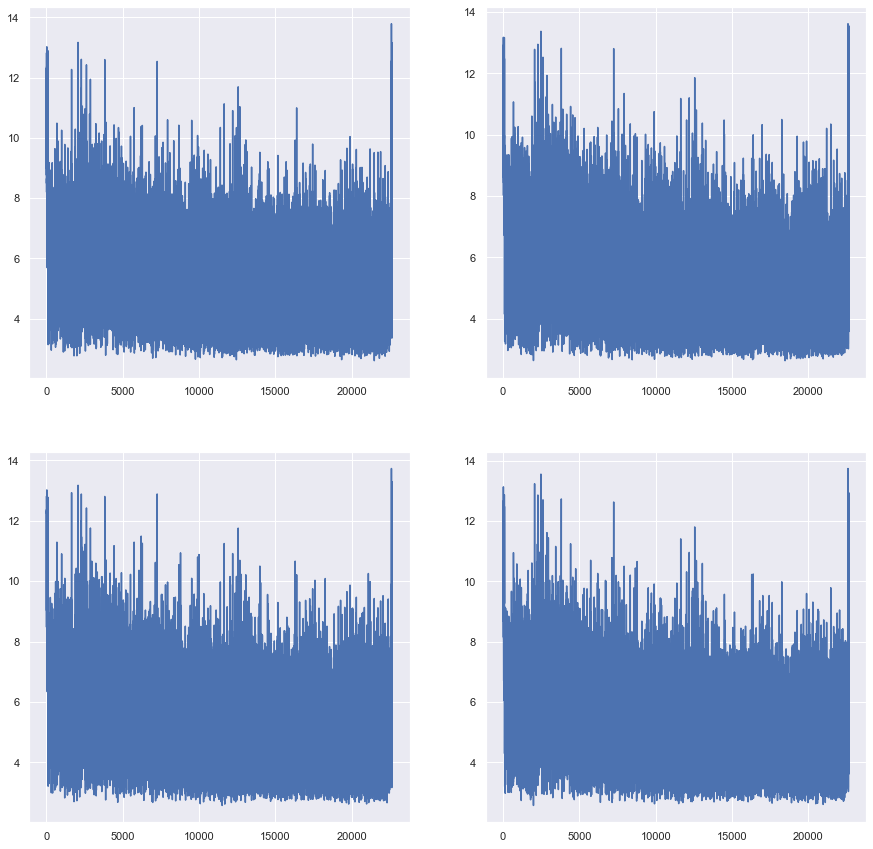

In [3]:
df = pd.read_csv("Leukemia_GSE22529_U133B.csv")
X = df.iloc[:,2:].to_numpy()

fig, axs = plt.subplots(2,2,figsize=(15,15))
count = 0
for i in range(axs.shape[0]):
    for j in range(axs.shape[1]):
        axs[i,j].plot(X[count])
        count += 1

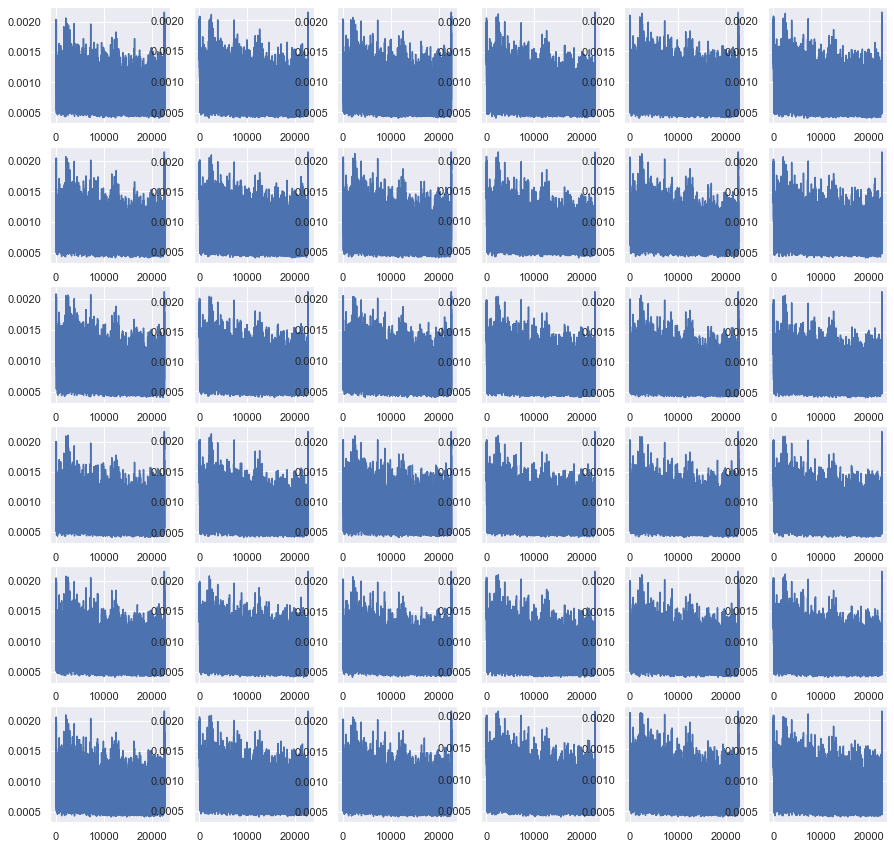

In [4]:
#Normalize
X = normalize(X)
fig, axs = plt.subplots(6,6,figsize=(15,15))
count = 0
for i in range(axs.shape[0]):
    for j in range(axs.shape[1]):
        axs[i,j].plot(X[count])
        count += 1

In [5]:
X = np.matrix(X)
m,n = X.shape

In [6]:
# Get parameters for autoencoder
batch_size, inner_iter, layers = get_params(m, n, compression = 0.02)
print(batch_size, inner_iter, layers)

26 2 [22645, 11548, 452]


In [7]:
with tf.Session() as sess:
    # layers = [n, int(n * 0.5)]
    rae = RDAE(sess=sess, lambda_=4000, layers_sizes=layers)
    # rae = RDAE(sess=sess, lambda_=2000, layers_sizes=[784, 400])

    L, S = rae.fit(X, sess=sess,
                   learning_rate=0.01,
                   batch_size=batch_size,
                   inner_iteration=inner_iter,
                   iteration=3, verbose=True)

    l21R = rae.getRecon(X, sess=sess)
    l21H = rae.transform(X, sess)


L shape: (22645,)
X size is: 1177540 (in case it requires adjusting too)
shrink parameter: 0.0015149762363191833
X shape:  (52, 22645)
L shape:  (22645,)
S shape:  (22645,)
mu:  2640305.4411721206
XFnorm:  1.0
Out iteration:  0
    iteration :  0 , cost :  0.0001698456
Break Criterion 1: the L and S are close enough to X 0.9967954310073627
Break Criterion 2: there is no changes for L and S 40.33354265606963
Out iteration:  1
    iteration :  0 , cost :  0.0001687588
Break Criterion 1: the L and S are close enough to X 0.9967954310073627
Break Criterion 2: there is no changes for L and S 0.0
Out iteration:  2
    iteration :  0 , cost :  0.0001687588
Break Criterion 1: the L and S are close enough to X 0.9967954310073627
Break Criterion 2: there is no changes for L and S 0.0


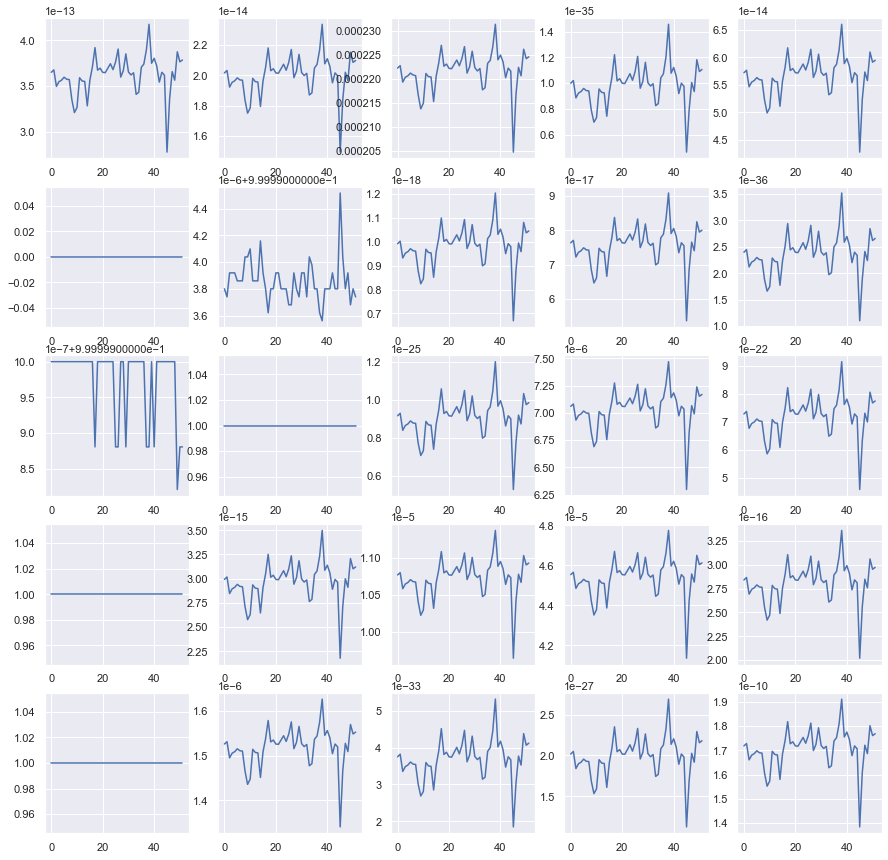

In [8]:
fig, axs = plt.subplots(5, 5, figsize=(15, 15))
count = 0
for i in range(axs.shape[0]):
    for j in range(axs.shape[1]):
        axs[i, j].plot(l21H[:, count])
        count += 1

l21R shape: (52, 22645)


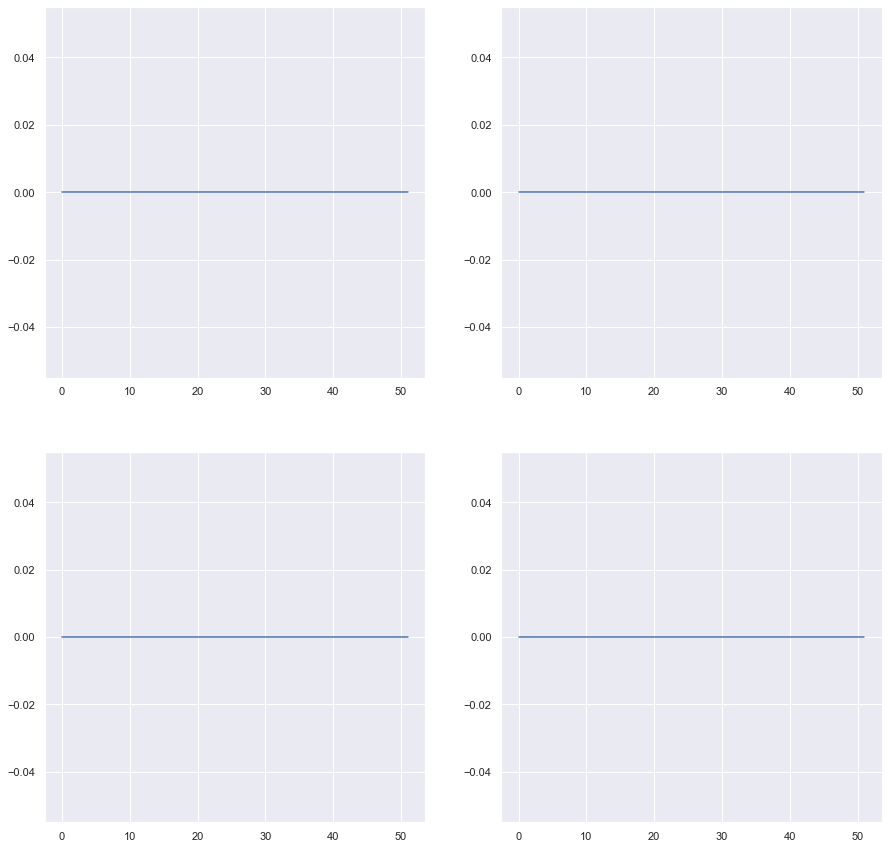

In [9]:
# Reconstruction
print("l21R shape:", l21R.shape)
fig, axs = plt.subplots(2,2,figsize=(15,15))
count = 0
for i in range(axs.shape[0]):
    for j in range(axs.shape[1]):
        axs[i,j].plot(l21R[:,count])
        count += 1
plt.show()
plt.close()

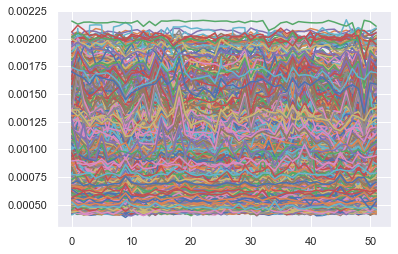

In [10]:
plt.clf()
L = X - S
for i in range(S.shape[1]):
    # plt.plot(S[:,i], label = "S val")
    # plt.plot(L[:,i], label = "L val")
    plt.plot(X[:,i], label = "X val")
plt.show()
plt.close()

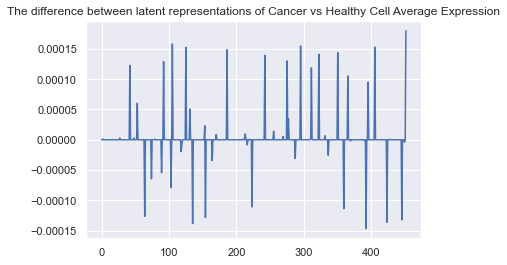

In [11]:
# plot average latent expression of cancer vs 
latent_cancer = np.mean(l21H[df['type'] == 'CLL' , :], axis = 0)
latent_healthy = np.mean(l21H[df['type'] == 'normal_B_Cell' , :], axis = 0)


diff = latent_cancer - latent_healthy
plt.title("The difference between latent representations of Cancer vs Healthy Cell Average Expression")
plt.plot(diff)
plt.show()
plt.close()

<Figure size 432x288 with 0 Axes>

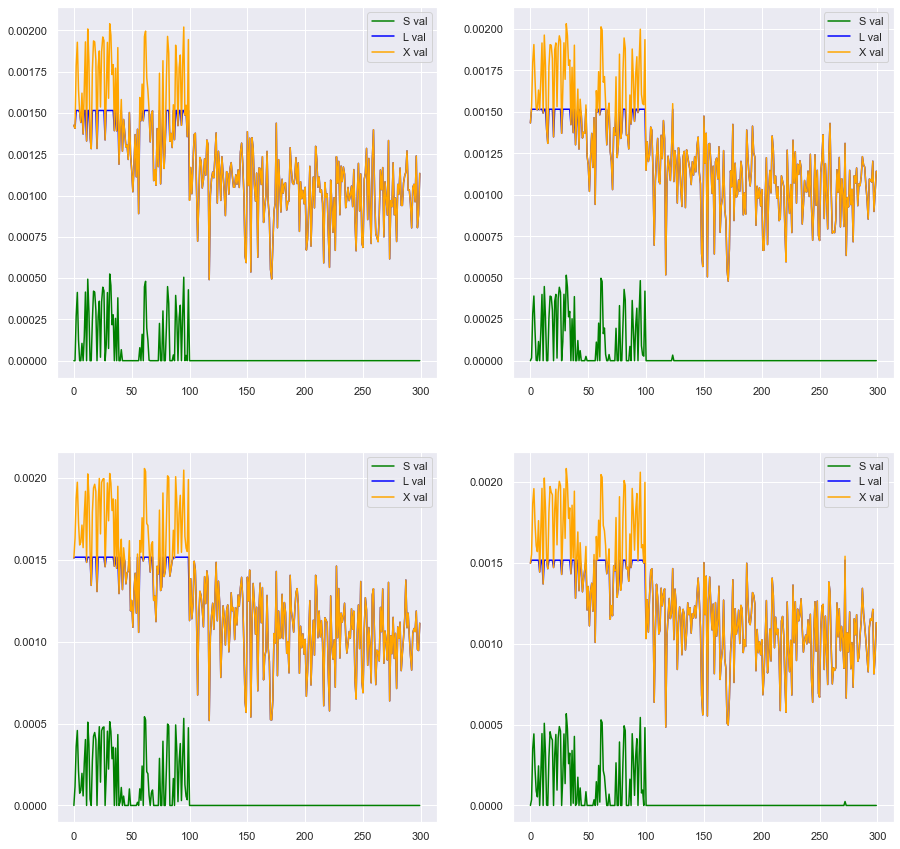

In [47]:
plt.clf()
fig, axs = plt.subplots(2,2,figsize=(15,15))
L = X - S
for i in range(axs.shape[0]):
    for j in range(axs.shape[1]):
        rand_sample = np.random.randint(0, L.shape[0])
        axs[i,j].plot(np.ravel(S[rand_sample,:300]), label = "S val", color='green')
        axs[i,j].plot(np.ravel(L[rand_sample,:300]), label = "L val", color='blue')
        axs[i,j].plot(np.ravel(X[rand_sample,:300]), label = "X val", color='orange')
        axs[i,j].legend()
plt.savefig('plots/RDAE.png')
plt.show()
plt.close()

## 2) Protein-Protein Interaction (PPI) Network

In [13]:
# About PPI data: 
# This section utilizes data on the human reference interactome (http://www.interactome-atlas.org/)
# Where protein-protein interactions were captured through high-throughput yeast two-hybrid experiments.

# Read in PPI data
cols = ['source', 'target']
ppi = pd.read_csv("HuRI.tsv", sep = '\t', names = cols)

# Call function to get mappings
ensembl_map = get_ensembl_mappings()

# Fill in missing key, value pairs. Values not returned from biomark manually collected.
ensembl_map['ENSG00000213029'] = 'SPHAR'
ensembl_map['ENSG00000203812']= 'HIST2H2AA3'
ensembl_map['ENSG00000272196']= 'HIST2H2AA4'
ensembl_map['ENSG00000283374']= 'TXNRD3NB'
ensembl_map['ENSG00000278272']= 'HIST1H3C'
ensembl_map['ENSG00000183729'] = 'NPBWR1'
ensembl_map['ENSG00000221972'] = 'C3orf36'
ensembl_map['ENSG00000181013']= 'C17orf47'
ensembl_map['ENSG00000243440'] = ''
ensembl_map['ENSG00000274267'] = 'HIST1H3B'
ensembl_map['ENSG00000184258'] = 'CDR1'
ensembl_map['ENSG00000214215']= 'C12orf74'


# Collect all protein values
all_proteins = list(set(np.append(ppi['source'].values, ppi['target'].values)))

# Check that dictionary contains all protein values in the PPI datas set
missing_vals = [i for i in all_proteins if i not in ensembl_map]
if len(missing_vals) > 0:
    print("Missing values:", missing_vals)

# Convert Ensembl ID's to gene IDs
new_source = [ensembl_map[ensembl_id] for ensembl_id in ppi['source']]
new_target = [ensembl_map[ensembl_id] for ensembl_id in ppi['target']]

# Update source and target (represented as genes)
ppi['source'] = new_source
ppi['target'] = new_target

### Louvain Community Detection

In [14]:
G = nx.Graph()
G = nx.from_pandas_edgelist(ppi, source = 'source', target = 'target')

# Apply the Louvain algorithm to compute the best partition
partition = community_louvain.best_partition(G)

# Save results
#f = open('gene_community_map.pkl', 'wb')
#pickle.dump(partition, f)
#f.close()

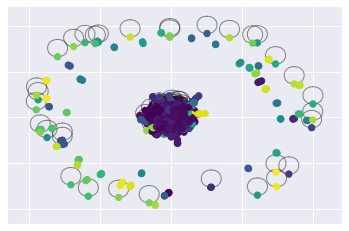

In [15]:
# Draw the graph
pos = nx.spring_layout(G)

# Color the map according to the partitions
color_map = cm.get_cmap('viridis', max(partition.values()) +1)
nx.draw_networkx_nodes(G, pos, partition.keys(), node_size = 40, cmap = color_map,\
                       node_color = list(partition.values()))
nx.draw_networkx_edges(G, pos, alpha = 0.5)
plt.show()
plt.close()

In [16]:
# Read in gene community map
gene_community_map = pd.read_pickle('gene_community_map.pkl')

# Read in gene keys
gene_key = pd.read_csv('probeID_to_geneID_mapping.csv')
gene_key['Gene Symbol'] = gene_key['Gene Symbol'].map(lambda gene: gene.split(' ///'))
probeID_gene_dict = gene_key.set_index('Probe Set ID').T.to_dict('list')

In [17]:
probe_ids = df.columns[2:]
# Mapping probe ids to the identified protein cluster:
probe_id_clusters = []
for probe_id in probe_ids:
    if probe_id in probeID_gene_dict.keys():
        probe_id_cluster = ''
        for gene in np.array(probeID_gene_dict[probe_id]).flatten():
            gene = gene.strip()
            if gene in gene_community_map.keys():
                probe_id_cluster = gene_community_map[gene]
                break
        if probe_id_cluster == '':
            probe_id_clusters.append(-1)
        else:
            probe_id_clusters.append(probe_id_cluster)
    else:
        probe_id_clusters.append(-1)

probe_id_clusters = np.array(probe_id_clusters)

In [18]:
# Percentage of missing data:
missing = np.average(probe_id_clusters == -1)
missing

0.7308898211525723

In [19]:
# Weight matrix won't change, so if we've already created it, don't recreate
if 'ppi_weights' in locals():
    pass
else:
    ppi_weights = pdist(np.expand_dims(probe_id_clusters, axis=1), weighted_pdist)

# Create distance matrix and adjust by community weights
y = pdist(L.T, 'euclidean')
weighted_y = ppi_weights * y
Z = weighted(weighted_y)
# Z = normalize(Z)
#
# # Transpose L and normalize so values correspond to Z adjustments
# L = normalize(L.T)

print(Z)

[[1.20000000e+01 1.80000000e+01 0.00000000e+00 2.00000000e+00]
 [2.20000000e+01 2.26450000e+04 0.00000000e+00 3.00000000e+00]
 [2.50000000e+01 2.26460000e+04 0.00000000e+00 4.00000000e+00]
 ...
 [4.52840000e+04 4.52850000e+04 4.07354915e-03 2.18670000e+04]
 [1.38880000e+04 4.52620000e+04 4.41727415e-03 7.78000000e+02]
 [4.52860000e+04 4.52870000e+04 5.30169332e-03 2.26450000e+04]]


In [20]:
color_dict = {'CLL': 'yellow' , 'normal_B_Cell': 'blue'}
row_colors = [color_dict[i] for i in df['type']]

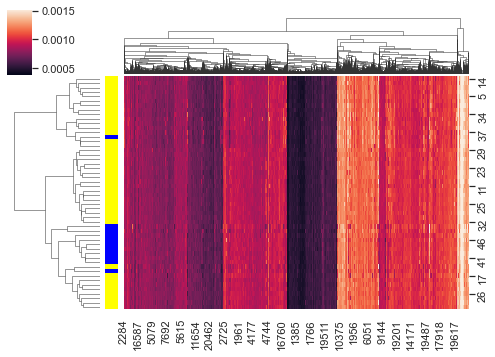

In [42]:
# import fastcluster
# Plot original L
g = sns.clustermap(L,
                   figsize=(7, 5),
                   row_cluster=True,
                   col_linkage=Z, 
                   row_colors = row_colors,
                   method = 'ward')

print(g)
plt.savefig('plots/L_hierarchy.png')
plt.show()
plt.close()

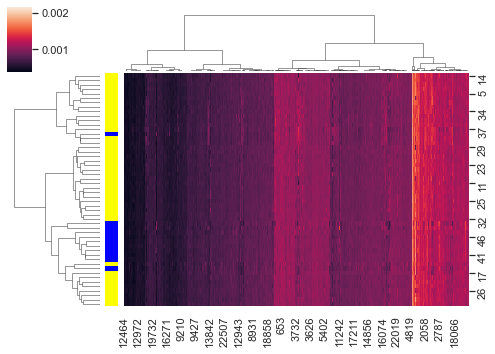

In [41]:
# Plot original X
g = sns.clustermap(normalize(X),
                   figsize=(7, 5),
                   row_cluster=True,
                   #col_linkage=Z, 
                   row_colors = row_colors,
                   method = 'ward')
plt.savefig('plots/X_hierarchy.png')
plt.show()
plt.close()

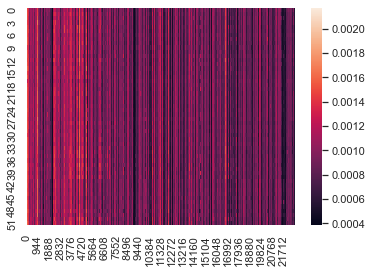

In [23]:
# heatmap without clustering
sns.heatmap(X)
plt.show()
plt.close()


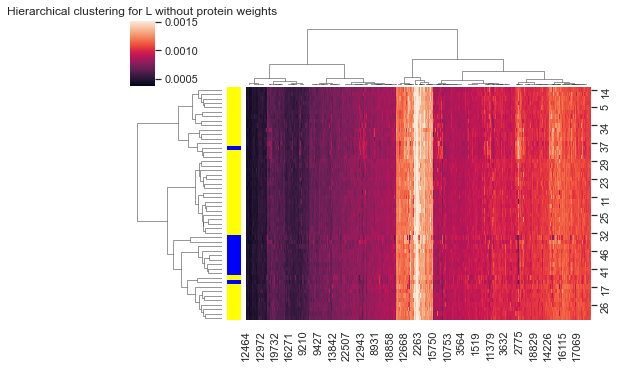

In [43]:
# Plot original L
g = sns.clustermap(L,
                   figsize=(7, 5),
                   row_cluster=True,
                   row_colors = row_colors,
                   method = 'ward'
                  )
plt.title("Hierarchical clustering for L without protein weights")
plt.savefig('plots/L_without_weights_hierarchy.png')
print(g)

In [26]:
result = fcluster(Z, t=.002, criterion='distance')
result

array([40, 40, 40, ..., 40, 40, 40], dtype=int32)

In [ ]:
print(np.unique(result))

In [ ]:
ax = sns.heatmap(L)

### Explore IKAROS-containing Clusters

In [27]:
from itertools import chain

# Define Ikaros family of genes
IKZF = ['IKZF5','IKZF4','IKZF4','IKZF3','IKZF2','IKZF1']

#Map gene cluster to ikaros genes
gene_to_probe_id = {np.array(v).flatten()[0]: k for k, v in probeID_gene_dict.items()}
ikzf_gene_clusters = {}
for ikzf in IKZF:
    ikzf_gene_clusters[ikzf] = result[np.where(probe_ids == gene_to_probe_id[ikzf])[0][0]]

ikzf_gene_clusters

ikzf_clusters = np.unique(list(chain(ikzf_gene_clusters.values())))
col_color_dict = {}
for cluster in np.unique(result):
    if cluster in ikzf_clusters:
        col_color_dict[cluster] = 'red'
    else:
        col_color_dict[cluster] = 'blue'

col_color = [col_color_dict[i] for i in result]

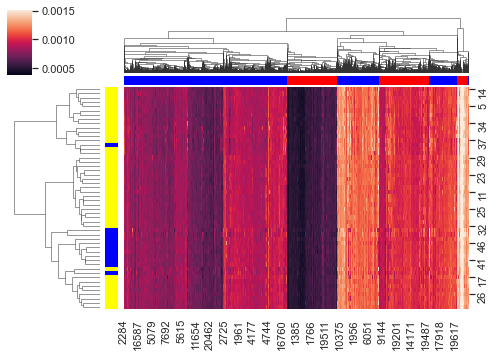

In [44]:
g = sns.clustermap(L,
                   figsize=(7, 5),
                   row_cluster=True,
                   col_linkage=Z,
                   row_colors = row_colors,
                   col_colors= col_color,
                   method = 'ward')
plt.savefig('plots/L_hierarchy_with_ikaros.png')

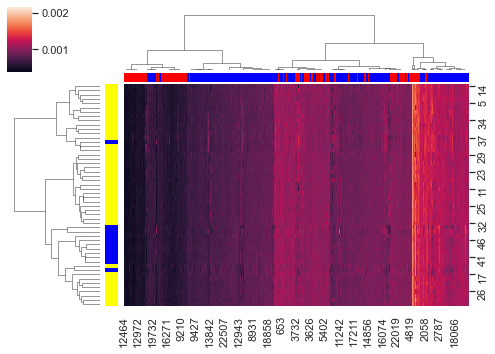

In [45]:
# Plot original X
g = sns.clustermap(normalize(X),
                   figsize=(7, 5),
                   row_cluster=True,
                   #col_linkage=Z,
                   row_colors = row_colors,
                   col_colors= col_color,
                   method = 'ward')

print(g)
plt.savefig('plots/X_hierarchy_with_ikaros.png')

plt.show()
plt.close()
